# Variational Quantum Eigensolver from Scratch

Implement a simple VQE library from scracth using QuTiP Qobjs and circuits and then use it to approximate the lowest eigenstate of a two qubit Hamiltonian (H) defined below.

Library features and limitations:

* Can decompose arbitrary Hamiltonians into Pauli operators (system resources allowing).
* Can only build Pauli measurement operators for one and two qubit operators (needs extending to support arbitrary
  size operators).

In [1]:
import logging

logging.basicConfig(level=logging.INFO)

In [2]:
%matplotlib inline

import math
import warnings

import qutip
import scipy.optimize
from qutip.qip.circuit import QubitCircuit

import vqefs.pauli
import vqefs.vqe

# ignore deprecation warning from the lastest ipykernel release -- hopefully the rest of the
# jupyter notebook system will catch up soon.
warnings.filterwarnings("ignore", message=r"`should_run_async`")

# Define H

In [3]:
H = qutip.Qobj([
    [1, 0, 0, 0],
    [0, 0, -1, 0],
    [0, -1, 0, 0],
    [0, 0, 0, 1],
], dims=[[2, 2], [2, 2]])
H

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  0.  1.]]

# Decompose H into a sum of Pauli matrix tensor products

* The function vqefs.pauli.decompose(...) returns the coefficients of each term.
* Terms with zero coefficients are excluded.
* The notation "XX" is short for "X ⊗ X".

In [4]:
h_coeffs = vqefs.pauli.decompose(H)
h_coeffs

{'II': 0.5, 'ZZ': 0.5, 'XX': -0.5, 'YY': -0.5}

# Construct measurement circuits for each Pauli term

* And display each measurement circuit so that we can inspect them for correctness. :)

In [5]:
h_measurement_circuits = {
    indices: vqefs.pauli.measurement_circuit(indices) for indices in h_coeffs
}

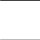

In [6]:
h_measurement_circuits["II"]

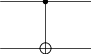

In [7]:
h_measurement_circuits["ZZ"]

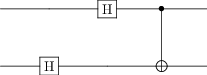

In [8]:
h_measurement_circuits["XX"]

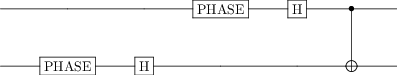

In [9]:
h_measurement_circuits["YY"]

# Define the form of the states to optimize over (i.e. the ansatz)

* And display an example of the circuit to check that it looks correct. :)

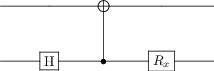

In [10]:
def h_ansatz(theta):
    qc = QubitCircuit(N=2)

    qc.add_gate("SNOT", targets=0)
    qc.add_gate("CNOT", controls=0, targets=1)
    qc.add_gate("RX", targets=0, arg_value=theta)

    #qc.add_gate("RX", targets=0, arg_value=theta)
    #qc.add_gate("CNOT", controls=0, targets=1)
    #qc.add_gate("SNOT", targets=0)
    
    return qc
    
h_ansatz(math.pi / 2)

In [11]:
initial_state = qutip.ket("00")
initial_state

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]

# Estimate the minimum energy

In [12]:
# set to analytical=True to use exact outcome probabilitites, set to False to simulate outcomes
analytical = True

def h_energy(x):
    theta, = x
    ansatz_circuit = h_ansatz(theta)
    energy = vqefs.vqe.estimate_energy(
        h_coeffs, h_measurement_circuits,
        initial_state, ansatz_circuit,
        runs=200, analytical=analytical
    )
    return energy

result = scipy.optimize.minimize(
    h_energy, x0=(math.pi / 4),
    bounds=[(-math.pi, math.pi)],
    options={"maxiter": 5, "disp": True},
)
result

      fun: -0.9999999999999994
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.11022303e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([3.14159265])

In [13]:
print(f"minimum energy: {result.fun}")
print(f"best theta: {result.x}")

minimum energy: -0.9999999999999994
best theta: [3.14159265]


In [14]:
# display final state
state, _prob = h_ansatz(result.x[0]).run(initial_state)
state

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.+0.j        ]
 [0.-0.70710678j]
 [0.-0.70710678j]
 [0.+0.j        ]]

# Compare with the analytical result

In [15]:
H.eigenstates()

(array([-1.,  1.,  1.,  1.]),
 array([Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[0.        ]
  [0.70710678]
  [0.70710678]
  [0.        ]],
        Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[1.]
  [0.]
  [0.]
  [0.]],
        Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[ 0.        ]
  [-0.70710678]
  [ 0.70710678]
  [ 0.        ]],
        Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[0.]
  [0.]
  [0.]
  [1.]]], dtype=object))

# One qubit example for testing

* Test a simple single qubit example to sanity check the algorithm.

In [16]:
h1d_coeffs = {"I": 1, "X": 2, "Y": 3, "Z": 4}
h1d_coeffs

{'I': 1, 'X': 2, 'Y': 3, 'Z': 4}

In [17]:
h1d = vqefs.pauli.compose(h1d_coeffs)
h1d

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 5.+0.j  2.-3.j]
 [ 2.+3.j -3.+0.j]]

In [18]:
h1d_measurement_circuits = {
    indices: vqefs.pauli.measurement_circuit(indices) for indices in h1d_coeffs
}

In [19]:
def h1d_ansatz(theta1, theta2):
    qc = QubitCircuit(N=1)
    qc.add_gate("RX", targets=0, arg_value=theta1)
    qc.add_gate("RY", targets=0, arg_value=theta2)
    return qc
    
h1d_ansatz(math.pi / 2, math.pi / 2)

In [20]:
initial_state = qutip.ket("0")
initial_state

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]

In [21]:
# set to analytical=True to use exact outcome probabilitites, set to False to simulate outcomes
analytical = True

def h1d_energy(x):
    theta1, theta2 = x
    ansatz_circuit = h1d_ansatz(theta1, theta2)
    energy = vqefs.vqe.estimate_energy(
        h1d_coeffs, h1d_measurement_circuits,
        initial_state, ansatz_circuit,
        runs=200, analytical=analytical
    )
    return energy

result = scipy.optimize.minimize(
    h1d_energy, x0=(math.pi / 4, math.pi / 4),
    bounds=[(-math.pi, math.pi), (-math.pi, math.pi)],
    options={"maxiter": 10, "disp": True},
)
result

      fun: -4.385164807129536
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([7.2830630e-06, 4.4408921e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 21
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([-0.59087139,  0.46364771])

In [22]:
print(f"minimum energy: {result.fun}")
print(f"best theta: {result.x}")

minimum energy: -4.385164807129536
best theta: [-0.59087139  0.46364771]


In [23]:
# display final state
h1d_ansatz(*result.x).run(initial_state)[0]

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.93108333-0.06689412j]
 [0.21979901+0.28336796j]]

In [24]:
h1d.eigenstates()

(array([-4.38516481,  6.38516481]),
 array([Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[-0.35862142+0.j        ]
  [ 0.51780325+0.77670488j]],
        Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[-0.93348309+0.j        ]
  [-0.19892737-0.29839106j]]], dtype=object))

# Two qubit example for testing

* Test a simple two qubit example to sanity check the algorithm.

In [25]:
h2d_coeffs = {"II": 1, "XX": 2, "YY": 3, "ZZ": 4}
h2d_coeffs

{'II': 1, 'XX': 2, 'YY': 3, 'ZZ': 4}

In [26]:
h2d = vqefs.pauli.compose(h2d_coeffs)
h2d

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 5.  0.  0. -1.]
 [ 0. -3.  5.  0.]
 [ 0.  5. -3.  0.]
 [-1.  0.  0.  5.]]

In [27]:
h2d_measurement_circuits = {
    indices: vqefs.pauli.measurement_circuit(indices) for indices in h2d_coeffs
}

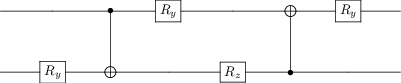

In [28]:
def h2d_ansatz(theta1, theta2, theta3, theta4):
    """ A fairly arbitrary 2-qubit ansatz. """
    qc = QubitCircuit(N=2)
    qc.add_gate("RY", targets=0, arg_value=theta1)    
    qc.add_gate("CNOT", controls=1, targets=0)
    qc.add_gate("RY", targets=1, arg_value=theta2)
    qc.add_gate("RZ", targets=0, arg_value=theta3)
    qc.add_gate("CNOT", controls=0, targets=1)
    qc.add_gate("RY", targets=1, arg_value=theta4)
    return qc
    
h2d_ansatz(math.pi / 2, math.pi / 2, math.pi / 2, math.pi / 2)

In [29]:
initial_state = qutip.ket("00")
initial_state

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]

In [30]:
# set to analytical=True to use exact outcome probabilitites, set to False to simulate outcomes
analytical = True

def h2d_energy(x):
    theta1, theta2, theta3, theta4 = x
    ansatz_circuit = h2d_ansatz(theta1, theta2, theta3, theta4)
    energy = vqefs.vqe.estimate_energy(
        h2d_coeffs, h2d_measurement_circuits,
        initial_state, ansatz_circuit,
        runs=200, analytical=analytical
    )
    return energy

result = scipy.optimize.minimize(
    h2d_energy, x0=(math.pi / 4, math.pi / 4, math.pi / 4, math.pi / 4),
    bounds=[(-math.pi, math.pi)] * 4,
    options={"maxiter": 20, "disp": True},
)
result

      fun: -7.9999999998905125
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.17239552e-05,  2.23820962e-05, -2.45137244e-05, -1.77635685e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 130
      nit: 15
     njev: 26
   status: 0
  success: True
        x: array([ 1.57079864e+00,  3.19713855e-06, -4.91044301e-06,  3.14159265e+00])

In [31]:
print(f"minimum energy: {result.fun}")
print(f"best theta: {result.x}")

minimum energy: -7.9999999998905125
best theta: [ 1.57079864e+00  3.19713855e-06 -4.91044301e-06  3.14159265e+00]


In [32]:
# display final state
h2d_ansatz(*result.x).run(initial_state)[0]

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[-1.13035786e-06-2.77527894e-12j]
 [ 7.07105962e-01+1.73610176e-06j]
 [-7.07107601e-01+1.73610579e-06j]
 [ 1.13036048e-06-2.77528537e-12j]]

In [33]:
h2d.eigenstates()

(array([-8.,  2.,  4.,  6.]),
 array([Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[ 0.        ]
  [-0.70710678]
  [ 0.70710678]
  [ 0.        ]],
        Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[0.        ]
  [0.70710678]
  [0.70710678]
  [0.        ]],
        Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[0.70710678]
  [0.        ]
  [0.        ]
  [0.70710678]],
        Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[-0.70710678]
  [ 0.        ]
  [ 0.        ]
  [ 0.70710678]]], dtype=object))